# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 2

Please use the following code to prepare the dataset.
 

In [58]:
from folktables.acs import adult_filter
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
random.seed(12)

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)


def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)

# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)
        
features.head()

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,21.0,20.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,65.0,8.0,33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33.0,40.0,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18.0,18.0,106.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,27.0,50.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
### Train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sample_indices = random.sample(range(len(features)), 20000)
features, labels = features.iloc[sample_indices], labels.iloc[sample_indices]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(columns= X_train.columns, data= scaler.transform(X_train), index = X_train.index)
X_test = pd.DataFrame(columns= X_test.columns, data = scaler.transform(X_test), index= X_test.index)

### Create one classifier to predict income on RAW DATA
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
gbc.fit(X_train, y_train)

### Report general accuracy 
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve
from sklearn.model_selection import cross_val_score

probs = gbc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
preds = accuracy_score(y_test, probs > 0.5)

print('Scores across all groups.')
print('AUC: ', auc(fpr, tpr))
print('Accuracy: ', preds)
print('Cross val score: ', cross_val_score(gbc, X_test, y_test))
print('---------------------------')

### report accuracy for gender groups and races

for i in set(X_test['SEX_Female']):
    X_test_temp = X_test[X_test["SEX_Female"] == i]
    drops = []
    for j in y_test.index:
        if j not in X_test_temp.index:
            drops.append(j)
    y_test_temp = y_test.drop(drops)
    temp_preds = gbc.predict(X_test_temp)
    accuracy = accuracy_score(y_test_temp, temp_preds)
    print(f'Accuracy for SEX {i}: {accuracy}')
    print('Cross val score: ', cross_val_score(gbc, X_test, y_test))
    print('---------------------------')

race_columns = [col for col in X_test.columns if "RAC1P" in col]

for i in set(X_test['RAC1P_Black or African American alone']):
    X_test_temp = X_test[X_test['RAC1P_Black or African American alone'] == i]
    drops = []
    for j in y_test.index:
        if j not in X_test_temp.index:
            drops.append(j)
    y_test_temp = y_test.drop(drops)
    temp_preds = gbc.predict(X_test_temp)
    accuracy = accuracy_score(y_test_temp, temp_preds)
    print(f'Accuracy for RAC1P {i}: {accuracy}')
    print('Cross val score: ', cross_val_score(gbc, X_test_temp, y_test_temp))
    print('---------------------------')

Scores across all groups.
AUC:  0.8889943875843846
Accuracy:  0.8385
Cross val score:  [0.8     0.835   0.8375  0.84125 0.8025 ]
---------------------------
Accuracy for SEX -0.9379228369755694: 0.8508853681267474
Cross val score:  [0.8     0.835   0.8375  0.84125 0.8025 ]
---------------------------
Accuracy for SEX 1.0661857890406046: 0.8241639697950378
Cross val score:  [0.8     0.835   0.8375  0.84125 0.8025 ]
---------------------------
Accuracy for RAC1P -0.27131041336679557: 0.8408424420154625
Cross val score:  [0.77896138 0.84933333 0.83066667 0.84933333 0.79866667]
---------------------------
Accuracy for RAC1P 3.6858150322747076: 0.8032128514056225
Cross val score:  [0.72       0.72       0.76       0.78       0.91836735]
---------------------------


In [60]:
Xs_train_p = X_train.values[:, 54:]
Xs_test_p = X_test.values[:, 54:]
Xs_train_np = X_train.values[:, :54]
Xs_test_np = X_test.values[:, :54]

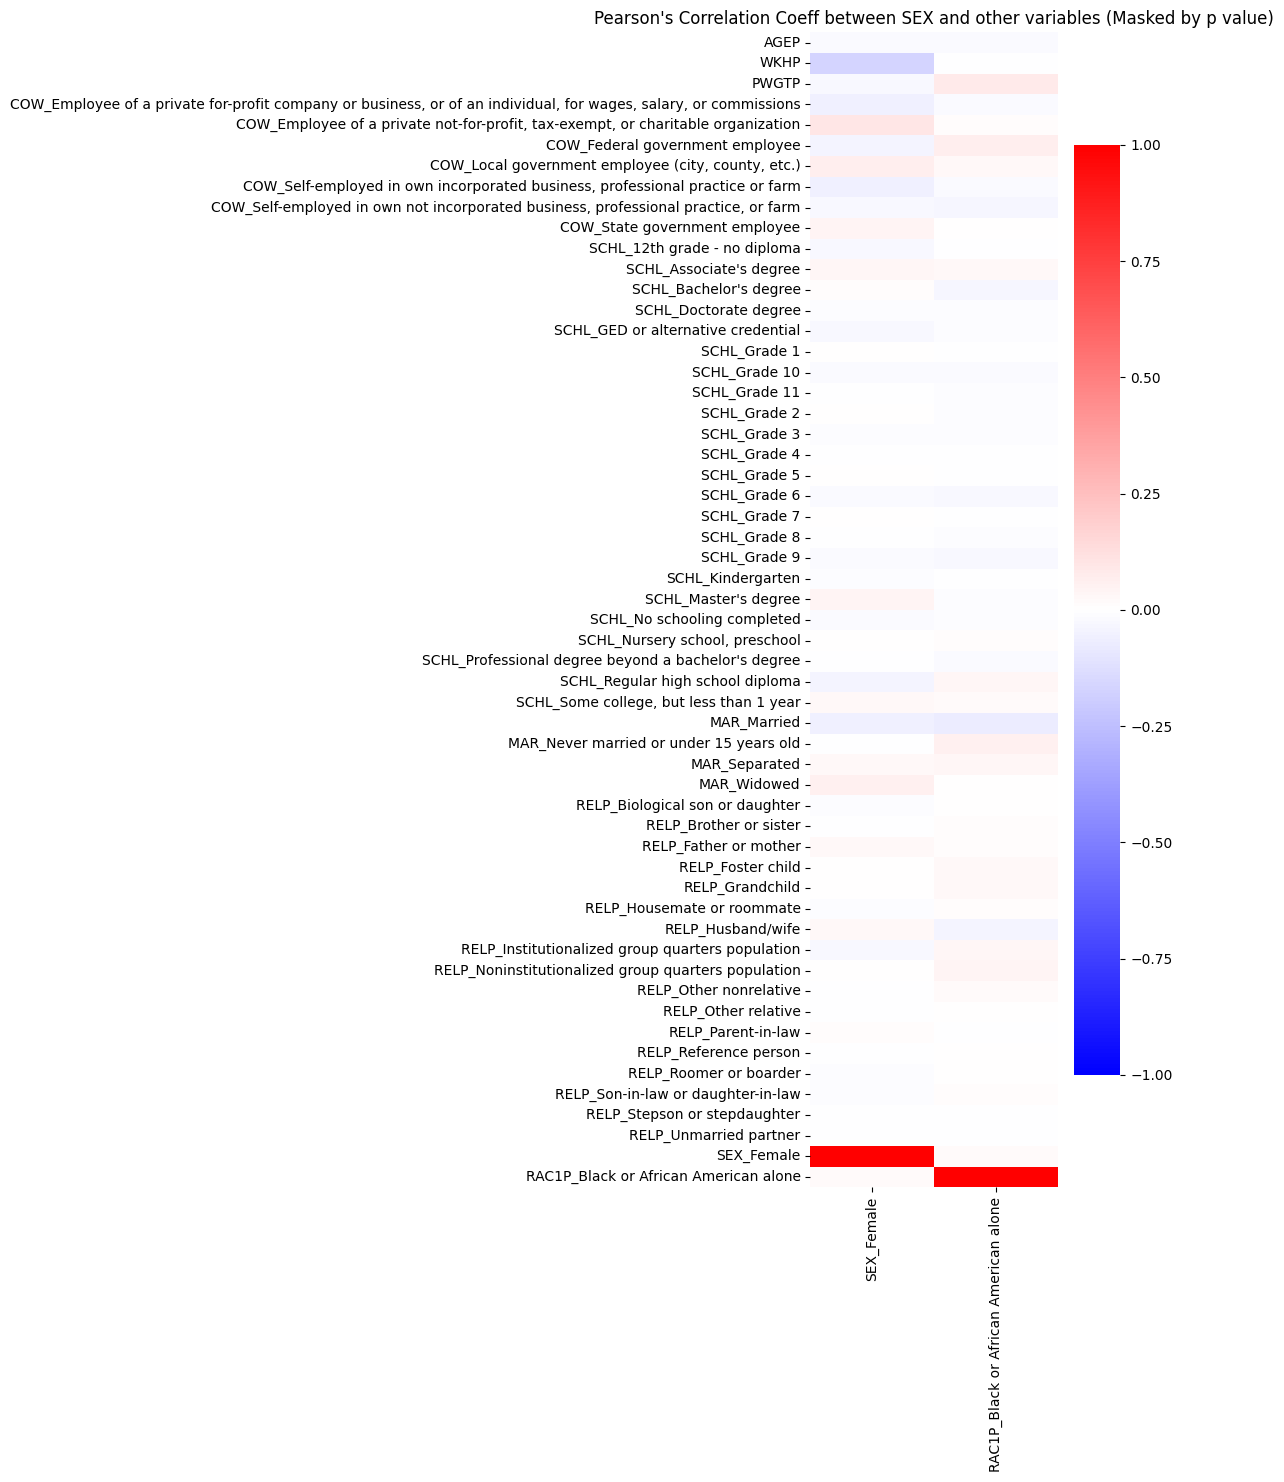

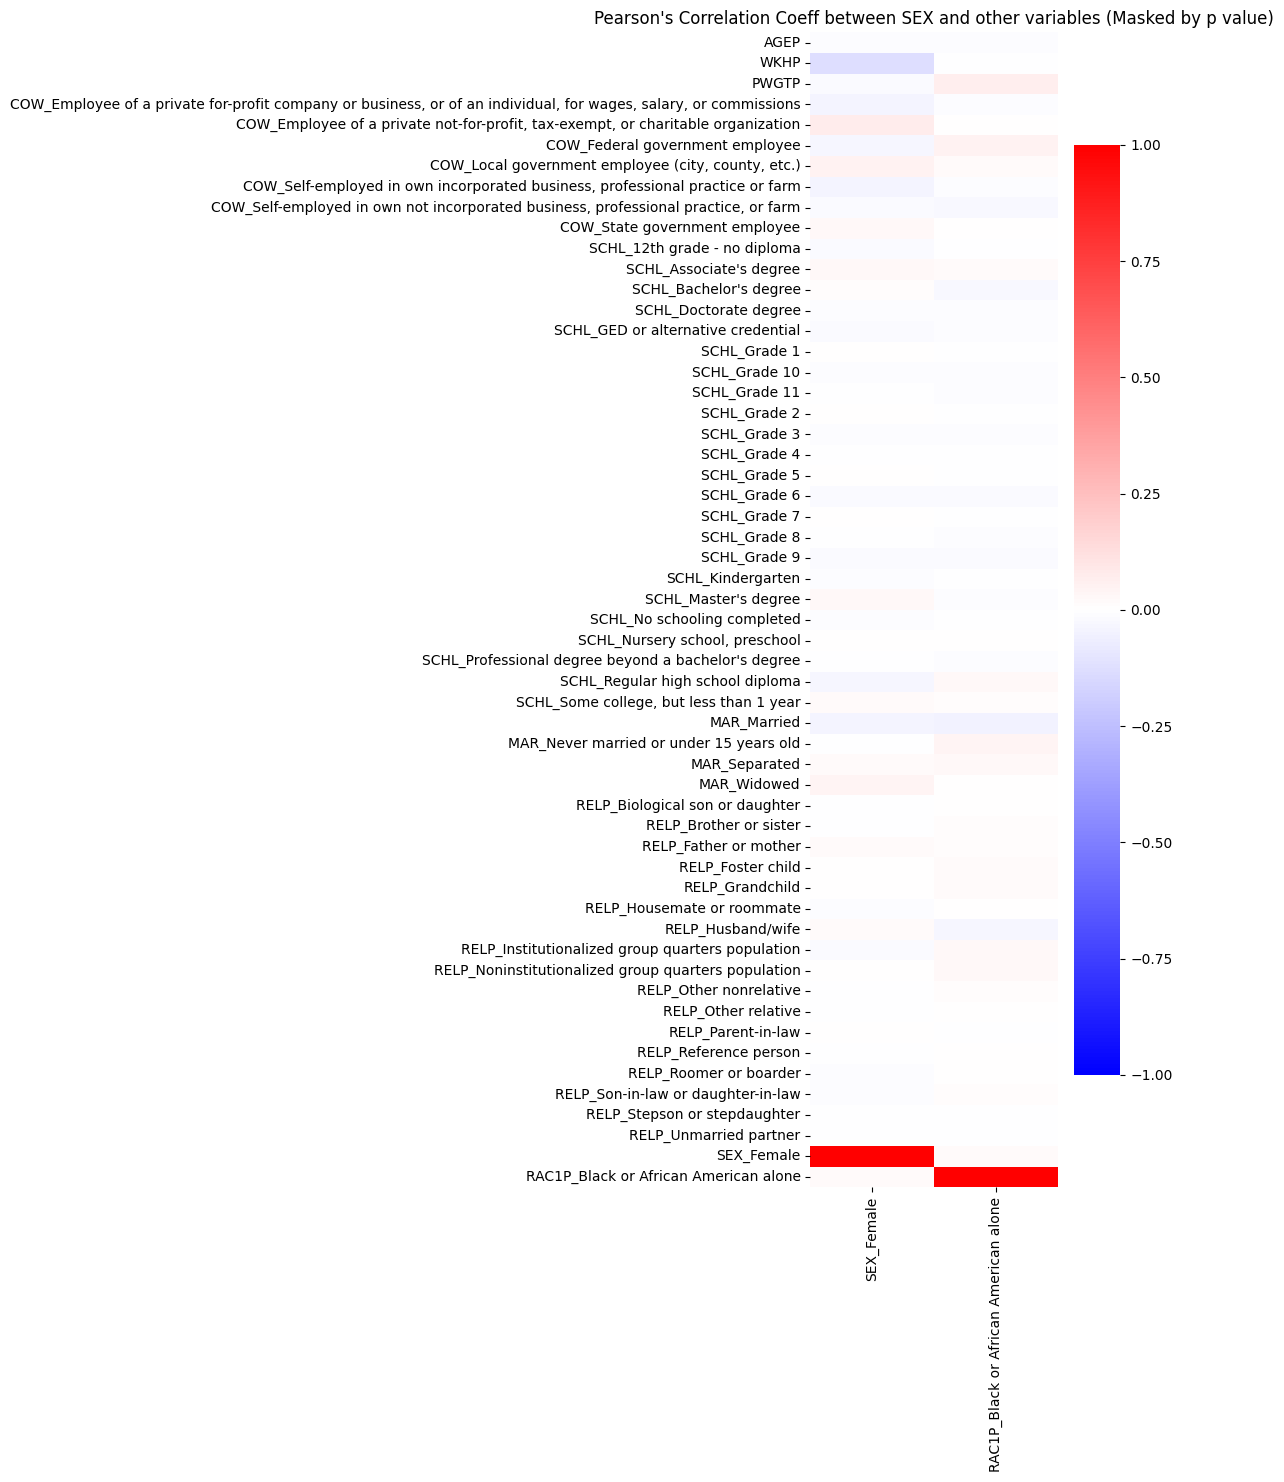

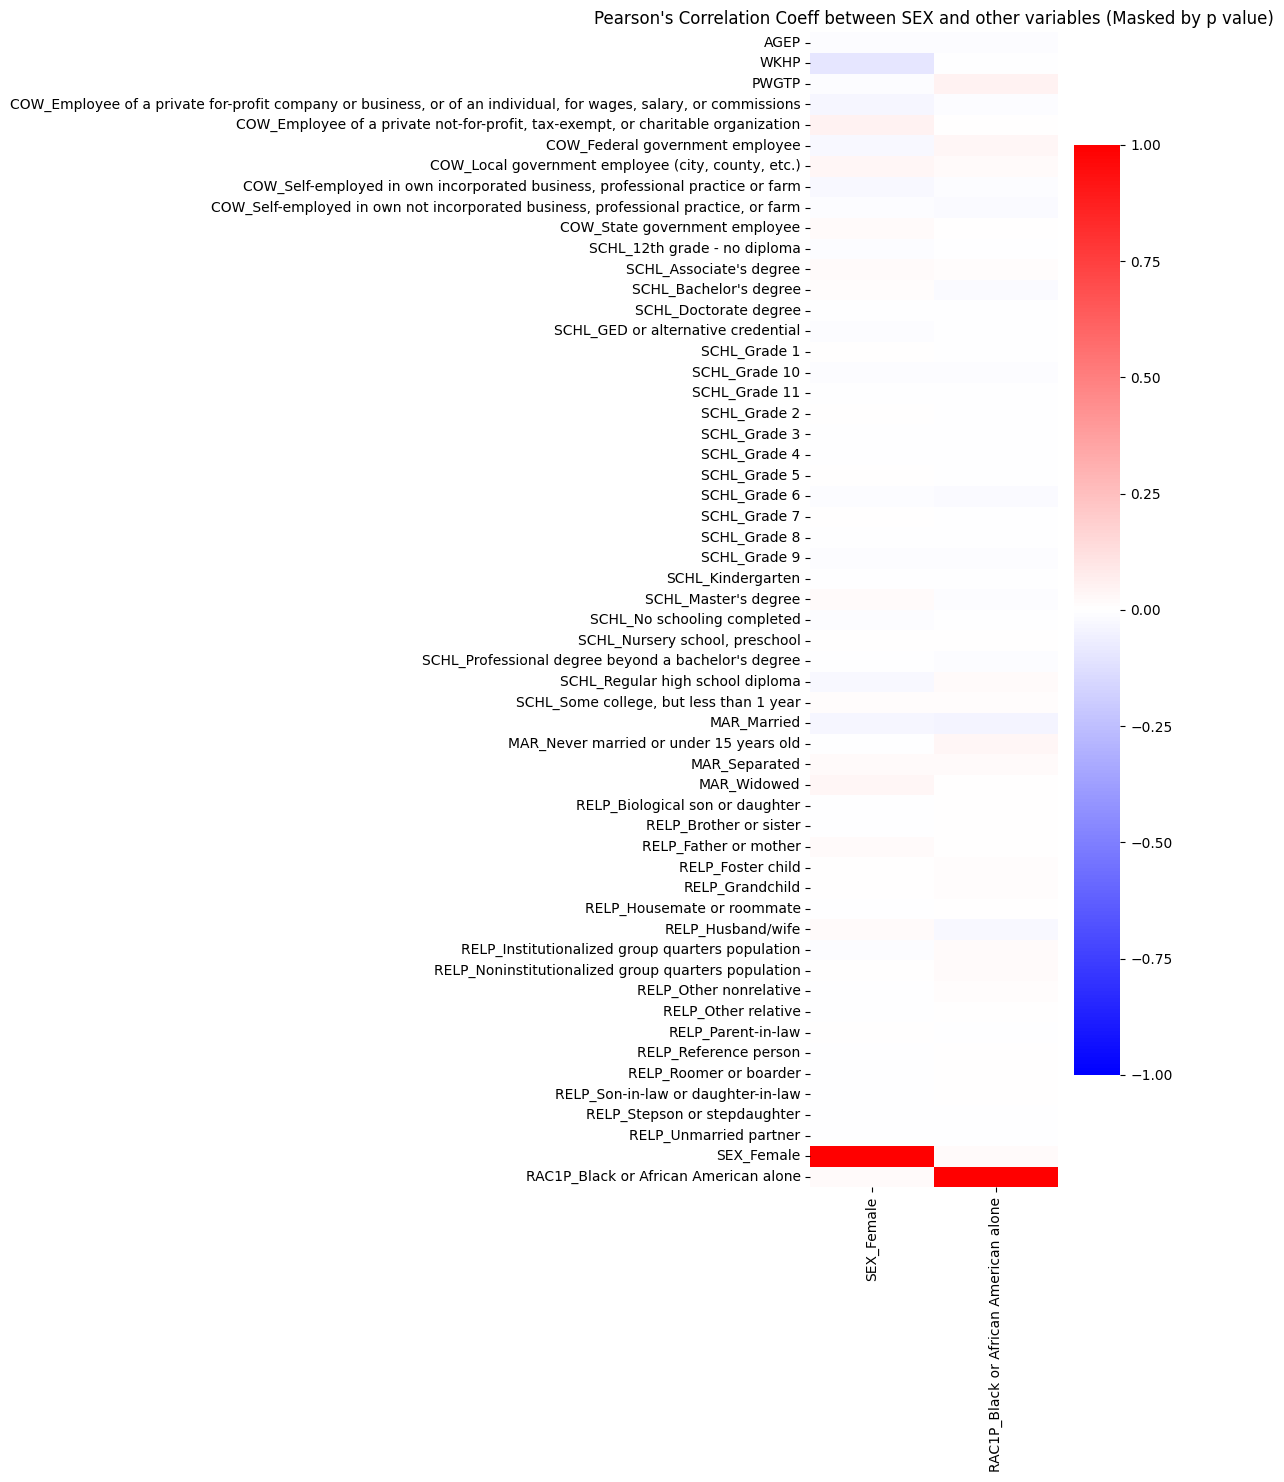

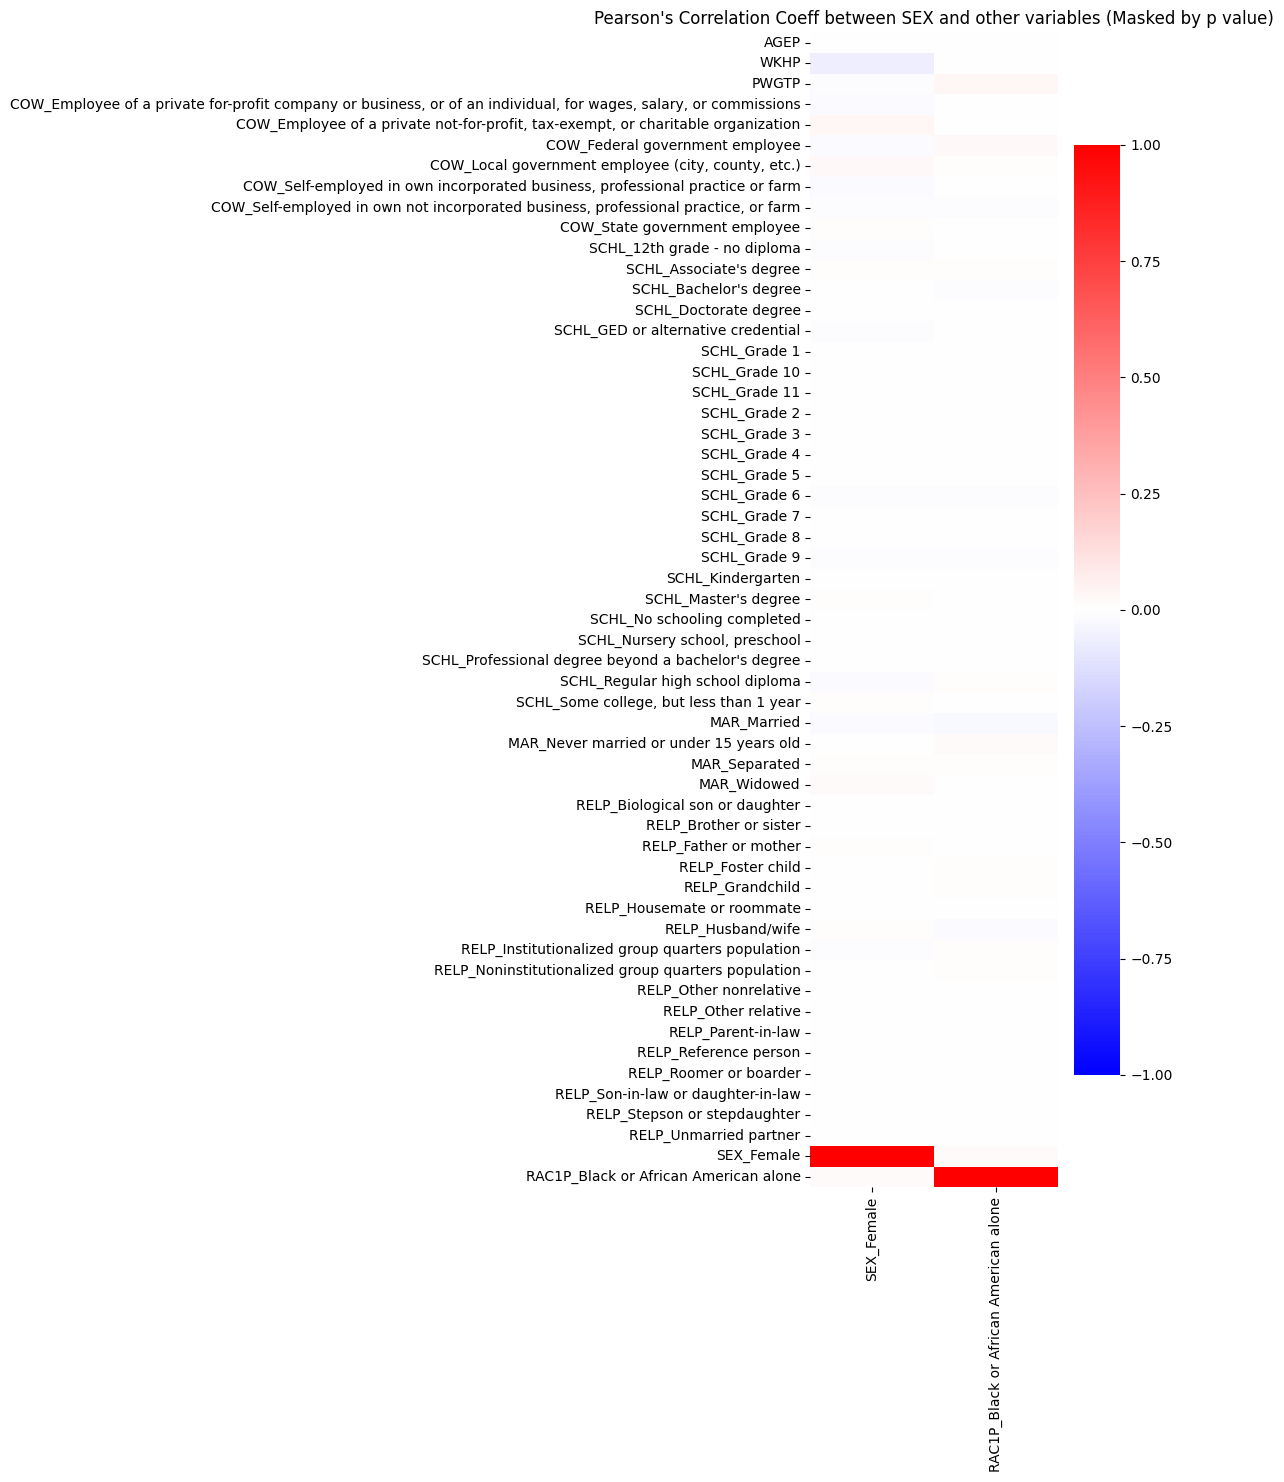

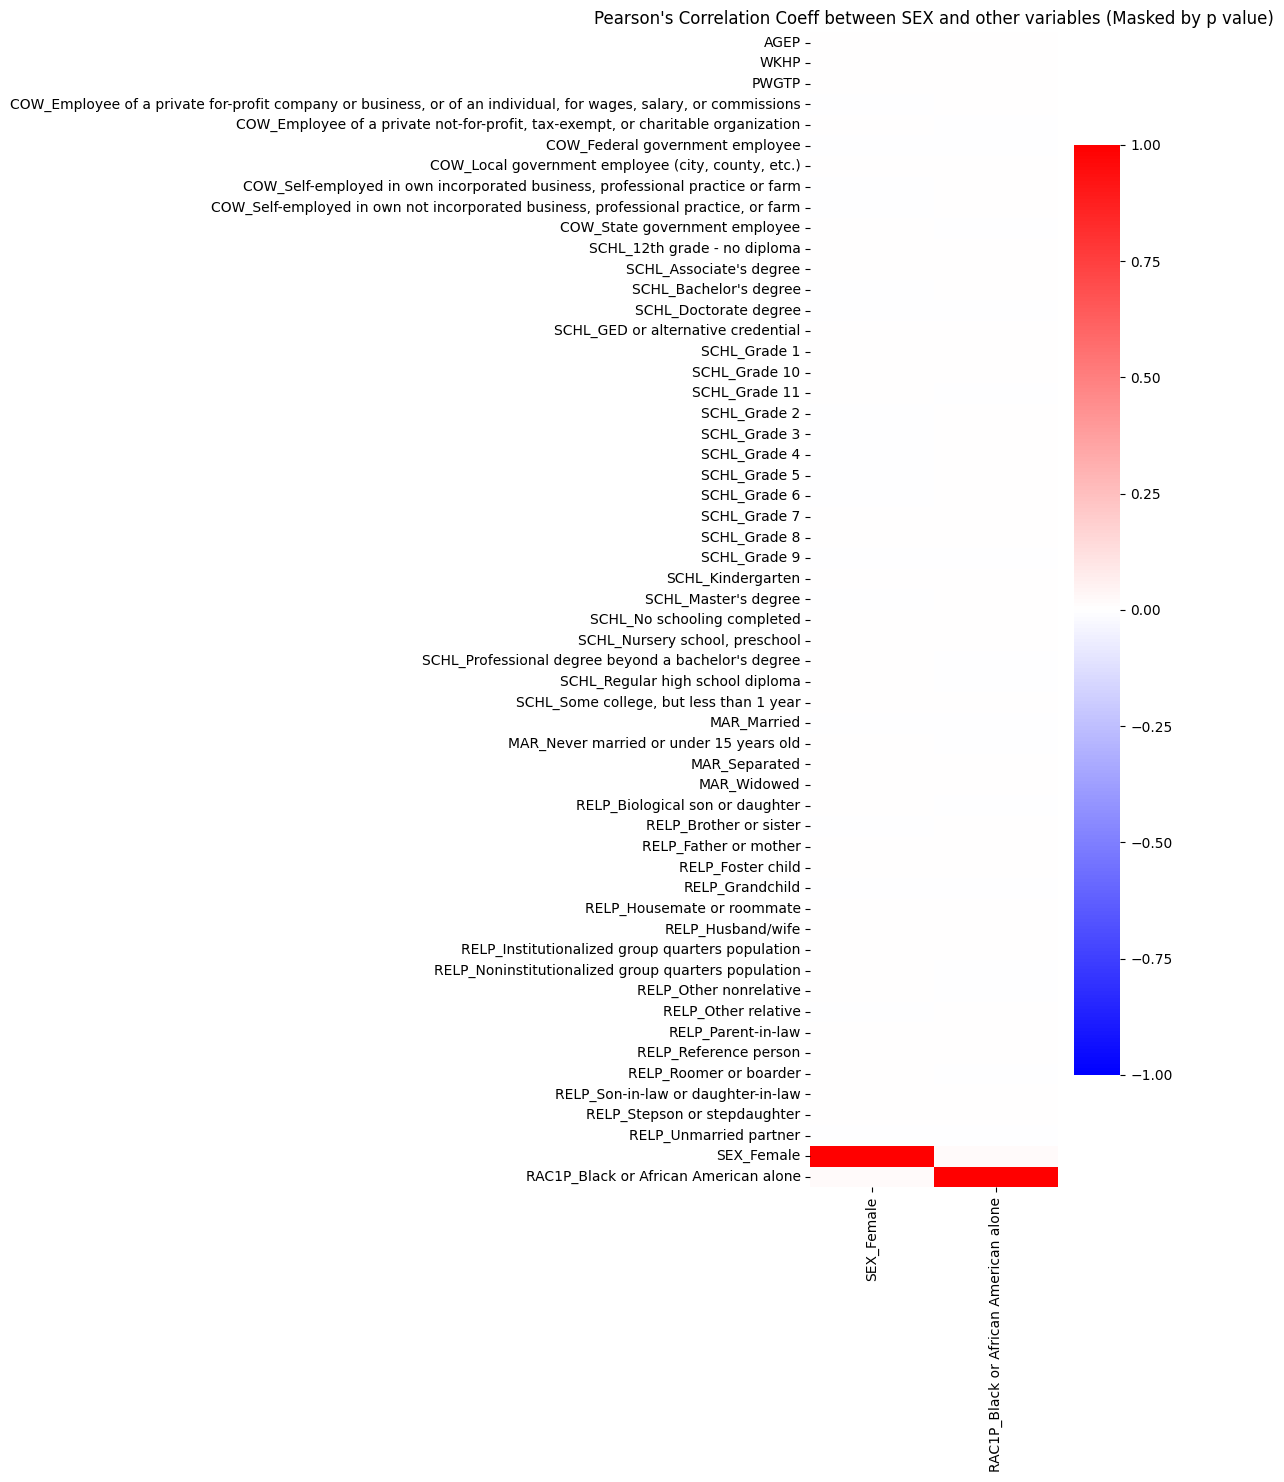

In [61]:
# ### Create a fairer version of the dataset to protect select groups
# protected_cols = ['RAC1P_Black or African American alone','SEX_Female']
# X_train_unprotected, X_train_protected = X_train.drop(columns = protected_cols), X_train[protected_cols]
# X_test_unprotected, X_test_protected = X_test.drop(columns = protected_cols), X_test[protected_cols]

def debias_features(Xs_np, Xs_p, lambda_param=0.7):
    import scipy
    assert Xs_np.shape[0]==Xs_p.shape[0]
    
    # Find orthonormal basis of protected features
    orthbasis = scipy.linalg.orth(Xs_p)

    # Debias nonprotected features
    Xs_np_debiased = Xs_np - lambda_param * (orthbasis @ orthbasis.T @ Xs_np)

    # Return debiased nonprotected features
    return Xs_np_debiased
accuracies_all = []
accuracies_sex_1 = []
accuracies_sex_2 = []
accuracies_race_1 = []
accuracies_race_2 = []
protected_cols = ['RAC1P_Black or African American alone', 'SEX_Female']

for idx, i in enumerate([0.1, 1/3, 0.5, 2/3, 1]):
    X_train_unprotected_debiased = debias_features(Xs_train_np, Xs_train_p, i)
    X_train_debiased = np.concatenate([X_train_unprotected_debiased, Xs_train_p], axis=1)
    # Compute correlation matrix
    n_features = X_train.shape[1]
    corr_ = np.zeros((n_features, n_features))
    p_ = np.zeros((n_features, n_features))
    for i in range(n_features):
        for j in range(n_features):
            corr_[i,j], p_[i,j] = pearsonr(X_train_debiased[:,i], X_train_debiased[:,j])
            corr_ = np.nan_to_num(corr_, 0)

    # Plot correlations with protected features
    plt.figure(idx, figsize=(4,15))
    sns.heatmap(corr_[:,54:], cmap="bwr", xticklabels=features.columns[54:], yticklabels=features.columns, vmin=-1, vmax=1)
    plt.title("Pearson's Correlation Coeff between SEX and other variables (Masked by p value)")
    plt.show()
    # Train a classifier on the debiased data for each group
    gbc.fit(X_train_debiased, y_train)
    probs = gbc.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    accuracy = accuracy_score(y_test, probs > 0.5)
    accuracies_all.append(accuracy)
    X_test_women = X_test[X_test['SEX_Female'] > 0]
    X_test_men = X_test[X_test['SEX_Female'] < 0]
    y_test_men = y_test.loc[X_test_men.index]
    y_test_women = y_test.loc[X_test_women.index]
    X_test_black = X_test[X_test['RAC1P_Black or African American alone'] > 0]
    X_test_non_black = X_test[X_test['RAC1P_Black or African American alone'] < 0]
    y_test_black = y_test.loc[X_test_black.index]
    y_test_non_black = y_test.loc[X_test_non_black.index]
    accuracies_race_1.append(accuracy_score(y_test_black, gbc.predict(X_test_black)))
    accuracies_race_2.append(accuracy_score(y_test_non_black, gbc.predict(X_test_non_black)))
    accuracies_sex_1.append(accuracy_score(y_test_women, gbc.predict(X_test_women)))
    accuracies_sex_2.append(accuracy_score(y_test_men, gbc.predict(X_test_men)))

In [62]:
stats = pd.DataFrame()
stats.index = [0.1, 1/3, 0.5, 2/3, 1]
stats['All'] = accuracies_all
stats['Women'] = accuracies_sex_1
stats['Men'] = accuracies_sex_2
stats['Black'] = accuracies_race_1
stats['Non-Black'] = accuracies_race_2

<Axes: ylabel='All'>

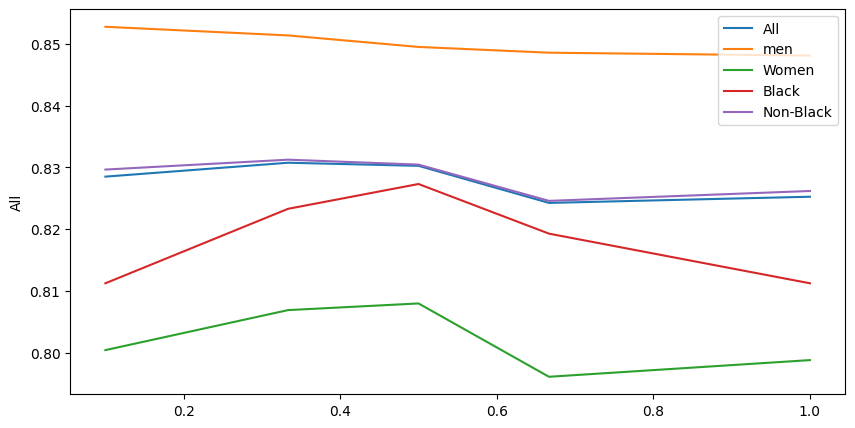

In [63]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=stats, x = stats.index, y = stats['All'], label = 'All', markers=True)
sns.lineplot(data=stats, x = stats.index, y = 'Men', label = 'men', markers=True)
sns.lineplot(data=stats, x = stats.index, y = 'Women', label = 'Women', markers=True)
sns.lineplot(data=stats, x = stats.index, y = 'Black', label = 'Black', markers=True)
sns.lineplot(data=stats, x = stats.index, y = 'Non-Black', label = 'Non-Black', markers=True)

In [64]:
### Build model using de-correlation effect from https://dl.acm.org/doi/10.1145/3375627.3375864

### Record results and plot differences in accuracies
